In [31]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import InputLayer, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications.efficientnet import EfficientNetB3
from tensorflow.keras.optimizers import Adam

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score



In [33]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import cv2
from sklearn.utils import resample
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from xgboost import XGBClassifier


In [34]:
data_path = os.path.join('/kaggle/input/covidx-cxr2')
train_data_path = os.path.join(data_path, 'train')
test_data_path = os.path.join(data_path,'test')

train_df = pd.read_csv(os.path.join(data_path, 'train.txt'), sep=" ", index_col=None, header=None)
test_df = pd.read_csv(os.path.join(data_path, 'test.txt'), sep=" ", index_col=None, header=None)

In [35]:
val_data_path = os.path.join(data_path,'val')

val_df = pd.read_csv(os.path.join(data_path, 'val.txt'), sep=" ", index_col=None, header=None)


In [7]:
val_df.head()

,0,1,2,3
0,ANON196,CR.1.2.840.113564.1722810170.20200318082923328...,positive,actmed
1,ANON170,CR.1.2.840.113564.1722810170.20200320011259312...,positive,actmed
2,S03044,sub-S03044_ses-E06138_run-1_bp-chest_vp-ap_cr-...,positive,bimcv
3,S03044,sub-S03044_ses-E07712_run-1_bp-chest_vp-ap_cr-...,positive,bimcv
4,S03044,sub-S03044_ses-E06790_run-1_bp-chest_vp-pa_dx-...,positive,bimcv


In [8]:
train_df.head()

,0,1,2,3
0,379,1e64990d1b40c1758a2aaa9c7f7a85_jumbo.jpeg,negative,cohen
1,379,7223b8ad031187d9a142d7f7ca02c9_jumbo.jpeg,negative,cohen
2,380,3392dc7d262e28423caca517f98c2e_jumbo.jpeg,negative,cohen
3,380,ec3a480c0926ded74429df416cfb05_jumbo.jpeg,negative,cohen
4,382,a72aeb349a63c79ed24e473c434efe_jumbo.jpg,negative,cohen


In [10]:
test_df.head()

,0,1,2,3
0,419639-003251,MIDRC-RICORD-1C-419639-003251-46647-0.png,positive,ricord
1,419639-001464,MIDRC-RICORD-1C-419639-001464-39871-0.png,positive,ricord
2,419639-000918,MIDRC-RICORD-1C-419639-000918-78965-0.png,positive,ricord
3,419639-003318,MIDRC-RICORD-1C-419639-003318-64285-0.png,positive,ricord
4,419639-001015,MIDRC-RICORD-1C-419639-001015-81591-0.png,positive,ricord


In [36]:
train_df.drop(columns = [0,3], axis=1, inplace=True)
test_df.drop(columns = [0,3], axis=1, inplace=True)
val_df.drop(columns = [0,3], axis=1, inplace=True)

In [12]:
test_df.head()

,1,2
0,MIDRC-RICORD-1C-419639-003251-46647-0.png,positive
1,MIDRC-RICORD-1C-419639-001464-39871-0.png,positive
2,MIDRC-RICORD-1C-419639-000918-78965-0.png,positive
3,MIDRC-RICORD-1C-419639-003318-64285-0.png,positive
4,MIDRC-RICORD-1C-419639-001015-81591-0.png,positive


In [37]:
train_df = train_df.rename(columns = {1:'image_name', 2:'diagnosis'})
test_df = test_df.rename(columns = {1:'image_name', 2:'diagnosis'})
val_df=val_df.rename(columns = {1:'image_name', 2:'diagnosis'})

In [38]:
train_df.head()

,image_name,diagnosis
0,1e64990d1b40c1758a2aaa9c7f7a85_jumbo.jpeg,negative
1,7223b8ad031187d9a142d7f7ca02c9_jumbo.jpeg,negative
2,3392dc7d262e28423caca517f98c2e_jumbo.jpeg,negative
3,ec3a480c0926ded74429df416cfb05_jumbo.jpeg,negative
4,a72aeb349a63c79ed24e473c434efe_jumbo.jpg,negative


In [39]:
train_df.diagnosis.value_counts()

diagnosis
positive    57199
negative    10664
Name: count, dtype: int64

In [40]:
test_df.diagnosis.value_counts()

diagnosis
positive    4241
negative    4241
Name: count, dtype: int64

In [41]:
val_df.diagnosis.value_counts()

diagnosis
positive    4241
negative    4232
Name: count, dtype: int64

In [42]:
train_df.isnull().sum()

image_name    0
diagnosis     0
dtype: int64

In [43]:
train_df.duplicated().sum()

0

In [44]:
test_df.isnull().sum()

image_name    0
diagnosis     0
dtype: int64

In [45]:
test_df.duplicated().sum()

0

In [46]:
val_df.isnull().sum()

image_name    0
diagnosis     0
dtype: int64

In [47]:
val_df.duplicated().sum()

0

In [48]:
import numpy as np

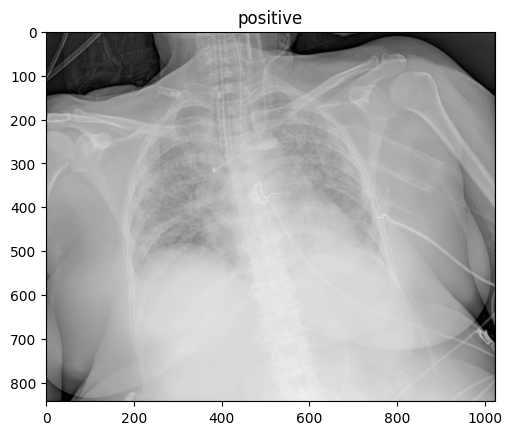

(843, 1024, 3)

In [49]:
rand_indx = np.random.randint(0,len(train_df),1)[0]
img = cv2.imread(os.path.join(train_data_path, train_df.image_name[rand_indx]))
plt.imshow(img/255)
plt.title(train_df.diagnosis[rand_indx])
plt.show()
img.shape

In [50]:
df_majority = train_df[train_df['diagnosis'] == 'positive']
df_minority = train_df[train_df['diagnosis'] == 'negative']

# Upsample the minority class  negative
df_minority_upsampled = resample(df_minority, 
                                 replace=True,     # Sample with replacement
                                 n_samples=len(df_majority), 
                                 random_state=42)

# Combine majority and upsampled minority
train_df = pd.concat([df_majority, df_minority_upsampled])

#  Shuffle the new training data
train_df = train_df.sample(frac=1, random_state=42).reset_index(drop=True)

In [51]:
train_df.diagnosis.value_counts()

diagnosis
negative    57199
positive    57199
Name: count, dtype: int64

In [52]:
test_df.diagnosis.value_counts()

diagnosis
positive    4241
negative    4241
Name: count, dtype: int64

In [53]:
def custom_preprocess(img):
    img = img.astype(np.uint8)
    lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    cl = clahe.apply(l)
    lab = cv2.merge((cl, a, b))
    img = cv2.cvtColor(lab, cv2.COLOR_LAB2RGB)

    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    _, mask = cv2.threshold(gray, 30, 255, cv2.THRESH_BINARY)
    mask = cv2.medianBlur(mask, 5)
    mask = cv2.cvtColor(mask, cv2.COLOR_GRAY2RGB)
    img = cv2.bitwise_and(img, mask)

    return img.astype(np.float32) / 255.0

In [54]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(
    preprocessing_function=custom_preprocess,
    rotation_range=15, zoom_range=0.1, horizontal_flip=True,
    width_shift_range=0.05, height_shift_range=0.05
)

val_datagen = ImageDataGenerator(preprocessing_function=custom_preprocess)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df, directory=train_data_path,
    x_col='image_name', y_col='diagnosis',
    target_size=IMG_SIZE, batch_size=BATCH_SIZE,
    class_mode='binary', shuffle=True
)

val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_df, directory=val_data_path,
    x_col='image_name', y_col='diagnosis',
    target_size=IMG_SIZE, batch_size=BATCH_SIZE,
    class_mode='binary', shuffle=False
)


Found 114398 validated image filenames belonging to 2 classes.
Found 8473 validated image filenames belonging to 2 classes.


In [58]:
from tensorflow.keras.applications import ResNet50

weights_path = '/kaggle/input/resnet50/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5'

base_model = ResNet50(weights=weights_path, include_top=False, input_shape=(224, 224, 3))

base_model.trainable = False 

In [59]:
  # Freeze the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=predictions)

model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy'])


In [61]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True)

In [62]:
EPOCHS = 5

history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=val_generator,
    callbacks=[early_stop, checkpoint]
)

Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1744909439.673394      95 service.cc:148] XLA service 0x7eced00128f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1744909439.674291      95 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1744909441.130522      95 cuda_dnn.cc:529] Loaded cuDNN version 90300


   2/3575 ━━━━━━━━━━━━━━━━━━━━ 3:00 51ms/step - accuracy: 0.4297 - loss: 1.1000   

I0000 00:00:1744909445.716407      95 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


3575/3575 ━━━━━━━━━━━━━━━━━━━━ 3605s 1s/step - accuracy: 0.5125 - loss: 0.7404 - val_accuracy: 0.5660 - val_loss: 0.6718
Epoch 2/5
3575/3575 ━━━━━━━━━━━━━━━━━━━━ 3057s 854ms/step - accuracy: 0.5406 - loss: 0.6753 - val_accuracy: 0.5698 - val_loss: 0.6496
Epoch 3/5
3575/3575 ━━━━━━━━━━━━━━━━━━━━ 3035s 848ms/step - accuracy: 0.5633 - loss: 0.6622 - val_accuracy: 0.6567 - val_loss: 0.6303
Epoch 4/5
3575/3575 ━━━━━━━━━━━━━━━━━━━━ 2970s 829ms/step - accuracy: 0.5758 - loss: 0.6542 - val_accuracy: 0.6774 - val_loss: 0.6137
Epoch 5/5
3575/3575 ━━━━━━━━━━━━━━━━━━━━ 3014s 841ms/step - accuracy: 0.5923 - loss: 0.6456 - val_accuracy: 0.6937 - val_loss: 0.6043


In [63]:
test_gen = ImageDataGenerator(
    preprocessing_function=custom_preprocess
).flow_from_dataframe(
    dataframe=test_df, directory=test_data_path,
    x_col='image_name', y_col='diagnosis',
    target_size=IMG_SIZE, batch_size=1,
    class_mode='binary', shuffle=False
)

Found 8482 validated image filenames belonging to 2 classes.


In [64]:
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score
y_test = test_gen.classes
y_proba_test = model.predict(test_gen, verbose=1)
y_pred_test = (y_proba_test > 0.5).astype(int)
print("\nResNet50 Test Results:")
print(classification_report(y_test, y_pred_test))
print("Accuracy:", accuracy_score(y_test,y_pred_test))
print("AUC Score:", roc_auc_score(y_test,y_proba_test))

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


8482/8482 ━━━━━━━━━━━━━━━━━━━━ 222s 25ms/step

ResNet50 Test Results:
              precision    recall  f1-score   support

           0       0.56      0.66      0.60      4241
           1       0.58      0.47      0.52      4241

    accuracy                           0.57      8482
   macro avg       0.57      0.57      0.56      8482
weighted avg       0.57      0.57      0.56      8482

Accuracy: 0.5669653383635935
AUC Score: 0.6003204922739979


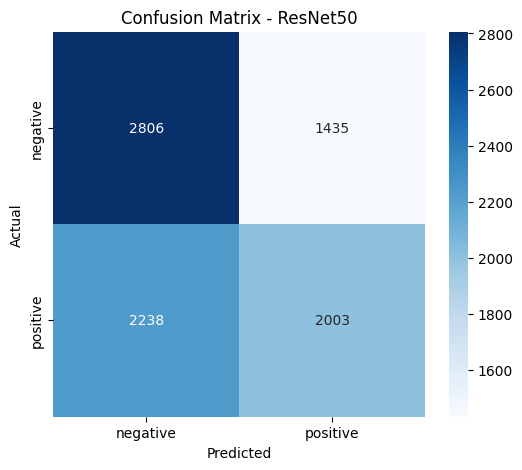

In [65]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred_test)
class_labels = ['negative', 'positive']

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix - ResNet50')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [66]:
pip install lime


Note: you may need to restart the kernel to use updated packages.


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━

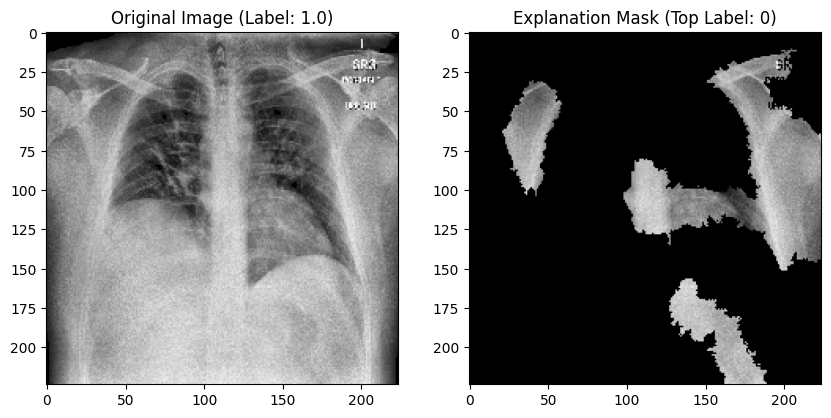

In [67]:
import numpy as np
import matplotlib.pyplot as plt
from lime import lime_image
from tensorflow.keras.preprocessing import image
import tensorflow as tf
explainer = lime_image.LimeImageExplainer()
def predict_fn(images):
    images = np.array(images)
    return model.predict(images)
idx = 0  
img = test_gen[idx][0]  
img_class = test_gen[idx][1]  
explanation = explainer.explain_instance(img[0], predict_fn, top_labels=2, hide_color=0, num_samples=1000)


temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=True)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(img[0])
plt.title(f"Original Image (Label: {img_class[0]})")

plt.subplot(1, 2, 2)
plt.imshow(temp)
plt.title(f"Explanation Mask (Top Label: {explanation.top_labels[0]})")
plt.show()
